# Importation des libraries

In [77]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Collecte des données à l'aide d'API

In [78]:
# Définir la période de temps
Start_date='2023-08-03' 
End_date='2024-08-03'

# Liste des symboles d'actions à récupérer
Tickers = ['UPS', 'MC', 'NKE', 'TSLA']

# Récupérer les données boursières via l'API Yahoo Finance
Data=yf.download(Tickers, start=Start_date, end=End_date, progress=False)

# Afficher les premières lignes
print(Data.head())

Price       Adj Close                                          Close  \
Ticker             MC         NKE        TSLA         UPS         MC   
Date                                                                   
2023-08-03  45.637726  107.110756  259.320007  173.880615  48.410000   
2023-08-04  45.933640  107.278374  253.860001  173.344147  48.119999   
2023-08-07  46.248646  108.924866  251.449997  174.503342  48.450001   
2023-08-08  45.628178  108.145988  249.699997  172.970520  47.799999   
2023-08-09  45.570911  108.145988  242.190002  171.840027  47.740002   

Price                                                High              ...  \
Ticker             NKE        TSLA         UPS         MC         NKE  ...   
Date                                                                   ...   
2023-08-03  108.639999  259.320007  181.500000  48.450001  109.089996  ...   
2023-08-04  108.809998  253.860001  180.940002  48.674999  110.309998  ...   
2023-08-07  110.480003  251.44999

In [79]:
# Réinitialise l'index pour inclure la colonne Date
Data=Data.reset_index()

In [80]:
# Convertit le DataFrame en format long avec les colonnes Date, Ticker et attributs
data_melted=Data.melt(id_vars=['Date'], var_name=['Attribute','Ticker'])

In [81]:
# Réorganise le DataFrame pour que les attributs (Open, High, Low, etc.) soient des colonnes
data_pivoted=data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

In [82]:
# Réinitialise l'index pour remettre Date et Ticker comme colonnes
stock_data=data_pivoted.reset_index()

In [83]:
# Afficher les premières lignes
print(stock_data.head())

Attribute       Date Ticker   Adj Close       Close        High         Low  \
0         2023-08-03     MC   45.637726   48.410000   48.450001   47.270000   
1         2023-08-03    NKE  107.110756  108.639999  109.089996  106.650002   
2         2023-08-03   TSLA  259.320007  259.320007  260.489990  252.000000   
3         2023-08-03    UPS  173.880615  181.500000  184.559998  181.259995   
4         2023-08-04     MC   45.933640   48.119999   48.674999   47.770000   

Attribute        Open      Volume  
0           47.480000    540800.0  
1          107.000000   5084300.0  
2          252.039993  97569100.0  
3          182.339996   3692800.0  
4           48.119999    345800.0  


In [86]:
# Convertir la colonne 'Date' au format datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Définir la colonne 'Date' comme index du dataframe
stock_data.set_index('Date', inplace=True)
print(stock_data.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2023-08-03     MC   45.637726   48.410000   48.450001   47.270000   47.480000   
2023-08-03    NKE  107.110756  108.639999  109.089996  106.650002  107.000000   
2023-08-03   TSLA  259.320007  259.320007  260.489990  252.000000  252.039993   
2023-08-03    UPS  173.880615  181.500000  184.559998  181.259995  182.339996   
2023-08-04     MC   45.933640   48.119999   48.674999   47.770000   48.119999   

Attribute       Volume  
Date                    
2023-08-03    540800.0  
2023-08-03   5084300.0  
2023-08-03  97569100.0  
2023-08-03   3692800.0  
2023-08-04    345800.0  


<Figure size 1200x600 with 0 Axes>

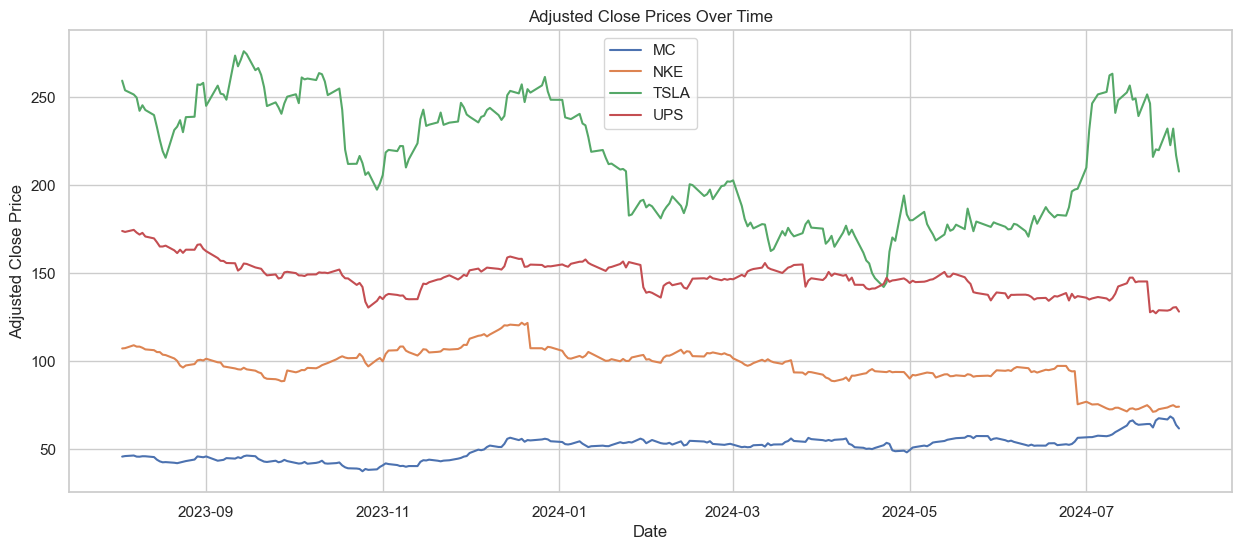

In [87]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Trace les données des prix de clôture ajustés
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Adj Close'], label=ticker)

plt.title('Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

Le graphique illustre les prix de clôture ajustés de quatre actions de août 2023 à août 2024. TSLA affiche les prix de clôture ajustés les plus élevés tout au long de la période, suivi de UPS. NKE et MC sont plus stables, avec des fluctuations de prix moins prononcées. TSLA, en particulier, présente une tendance haussière notable.

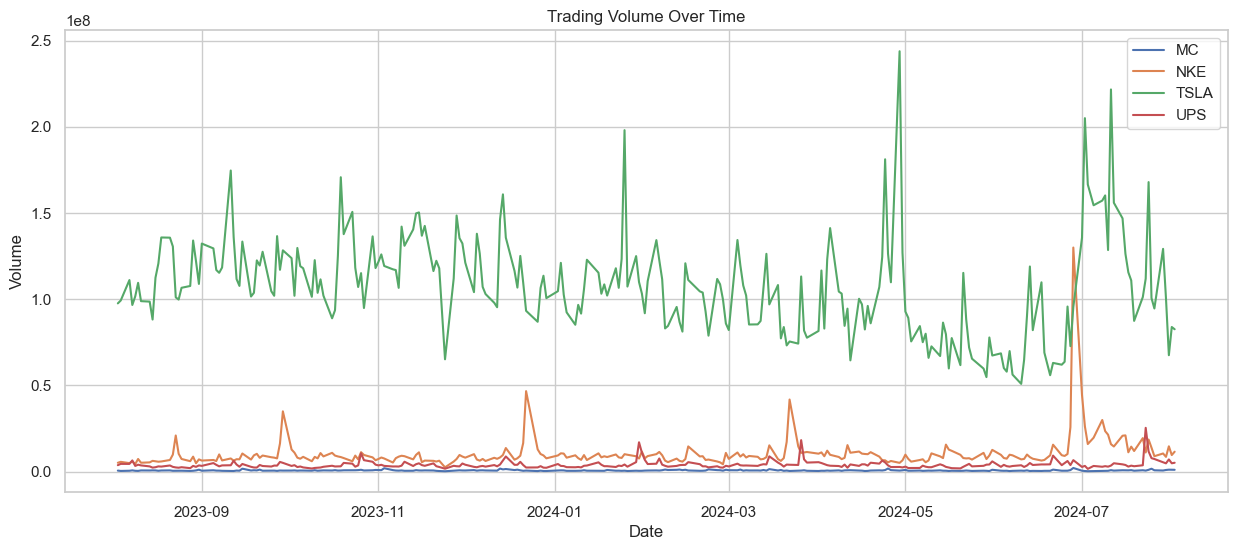

In [88]:
# Visualise des volumes de ces actions
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Volume'], label=ticker)

plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

Le graphique des volumes de transactions montre que TSLA a connu des périodes de forte activité de trading, avec plusieurs pics significatifs tout au long de la période. UPS et NKE affichent des volumes de transactions plus stables, mais connaissent aussi des moments d'activité accrue. À l'inverse, MC a des volumes de transactions faibles et constants, indiquant une activité de trading minimale. Ces données sont essentielles pour comprendre les mouvements de prix et les comportements de trading, facilitant ainsi des décisions d'investissement informées.

# Détection d'anomalies

In [89]:
# Calcul des Z-scores pour identifier les anomalies

# Fonction pour détecter les anomalies
def detect_anomalies(df, column):
    df_copy = df.copy()

    # Calculer les Z-scores et les ajouter en tant que nouvelle colonne
    df_copy['Z-score'] = zscore(df_copy[column])

    # Identifier les anomalies où |Z-score| est supérieure à 2 (seuil courant pour les anomalies)
    anomalies = df_copy[abs(df_copy['Z-score']) > 2]
    return anomalies

In [90]:
# Création des DataFrames pour les anomalies des prix ajustés et du volume
anomalies_adj_close = pd.DataFrame()
anomalies_volume = pd.DataFrame()

In [91]:
# Afficher les anomalies pour les prix ajustés et le volume

for ticker in stock_data['Ticker'].unique():
    data_ticker = stock_data[stock_data['Ticker'] == ticker]

    adj_close_anomalies = detect_anomalies(data_ticker, 'Adj Close')
    volume_anomalies = detect_anomalies(data_ticker, 'Volume')

    # Concaténation des anomalies
    anomalies_adj_close = pd.concat([anomalies_adj_close, adj_close_anomalies])
    anomalies_volume = pd.concat([anomalies_volume, volume_anomalies])

print(anomalies_adj_close.head())

Attribute  Ticker  Adj Close      Close       High        Low       Open  \
Date                                                                       
2023-10-25     MC  37.304382  39.080002  40.400002  38.580002  39.900002   
2024-07-16     MC  65.640846  66.279999  66.550003  64.040001  64.040001   
2024-07-17     MC  66.205353  66.849998  67.500000  65.419998  65.930000   
2024-07-18     MC  64.462318  65.089996  68.500000  64.955002  66.599998   
2024-07-19     MC  63.719555  64.339996  65.510002  63.740002  65.040001   

Attribute     Volume   Z-score  
Date                            
2023-10-25  833400.0 -2.047018  
2024-07-16  731500.0  2.307882  
2024-07-17  688500.0  2.394638  
2024-07-18  814300.0  2.126759  
2024-07-19  472600.0  2.012608  


In [92]:
print(anomalies_volume.head())

Attribute  Ticker  Adj Close      Close       High        Low       Open  \
Date                                                                       
2023-09-15     MC  46.220009  48.419998  48.650002  47.799999  47.950001   
2023-11-03     MC  41.389915  43.360001  44.279999  40.680000  44.000000   
2023-12-13     MC  52.869293  54.590000  54.865002  51.700001  52.669998   
2023-12-14     MC  55.726303  57.540001  57.980000  55.320000  55.840000   
2023-12-15     MC  56.365501  58.200001  58.669998  56.740002  57.230000   

Attribute      Volume   Z-score  
Date                             
2023-09-15  1650900.0  3.605544  
2023-11-03  1918700.0  4.551121  
2023-12-13  1712700.0  3.823754  
2023-12-14  1237500.0  2.145868  
2023-12-15  1459100.0  2.928317  


In [106]:
# Afficher les points d'anomalies pour le prix de clôture ajusté de chaque action

def plot_anomalies_adj_close(ticker, anomalies_adj_close):
    # Filtrer les données principales et les anomalies pour l'action spécifiée
    data_ticker = stock_data[stock_data['Ticker'] == ticker]
    adj_close_anomalies = anomalies_adj_close[anomalies_adj_close['Ticker'] == ticker]
    
    # Créer le graphique
    fig, ax = plt.subplots(figsize=(15, 6))

    # Tracer le prix de clôture ajusté
    ax.plot(data_ticker.index, data_ticker['Adj Close'], label='Adj Close', color='green')
    ax.scatter(adj_close_anomalies.index, adj_close_anomalies['Adj Close'], color='red', label='Anomalies')
    ax.set_title(f'{ticker} Adjusted Close Price and Anomalies')
    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted Close Price')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

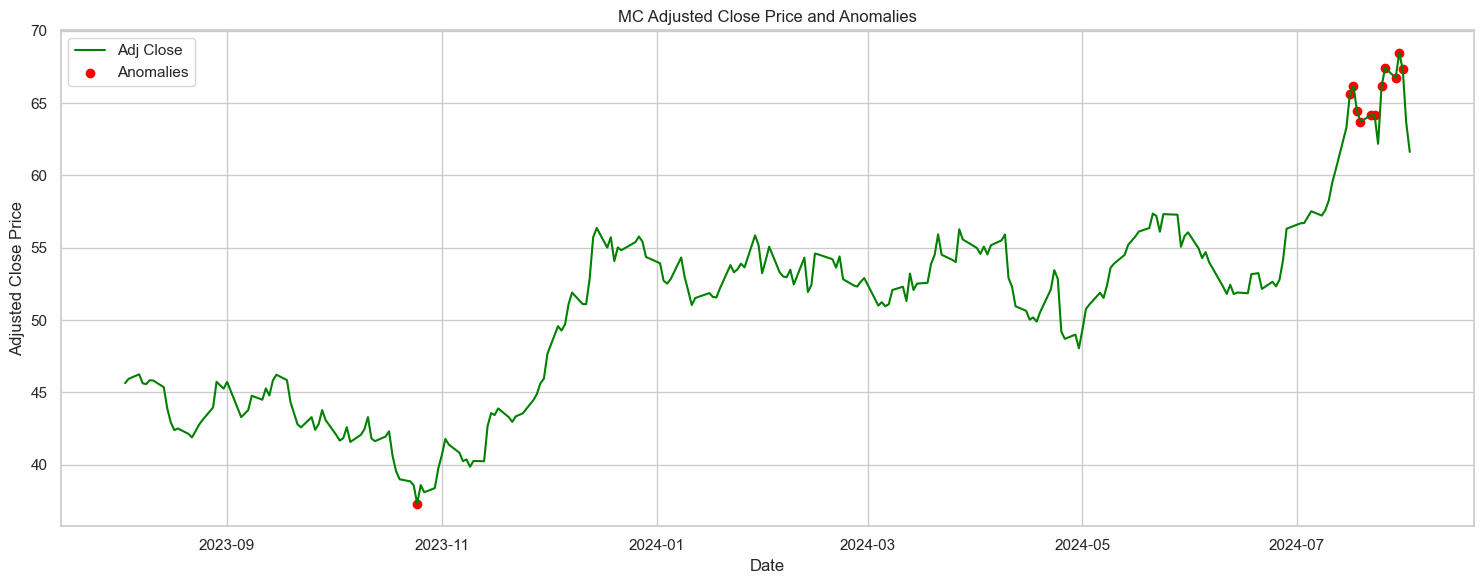

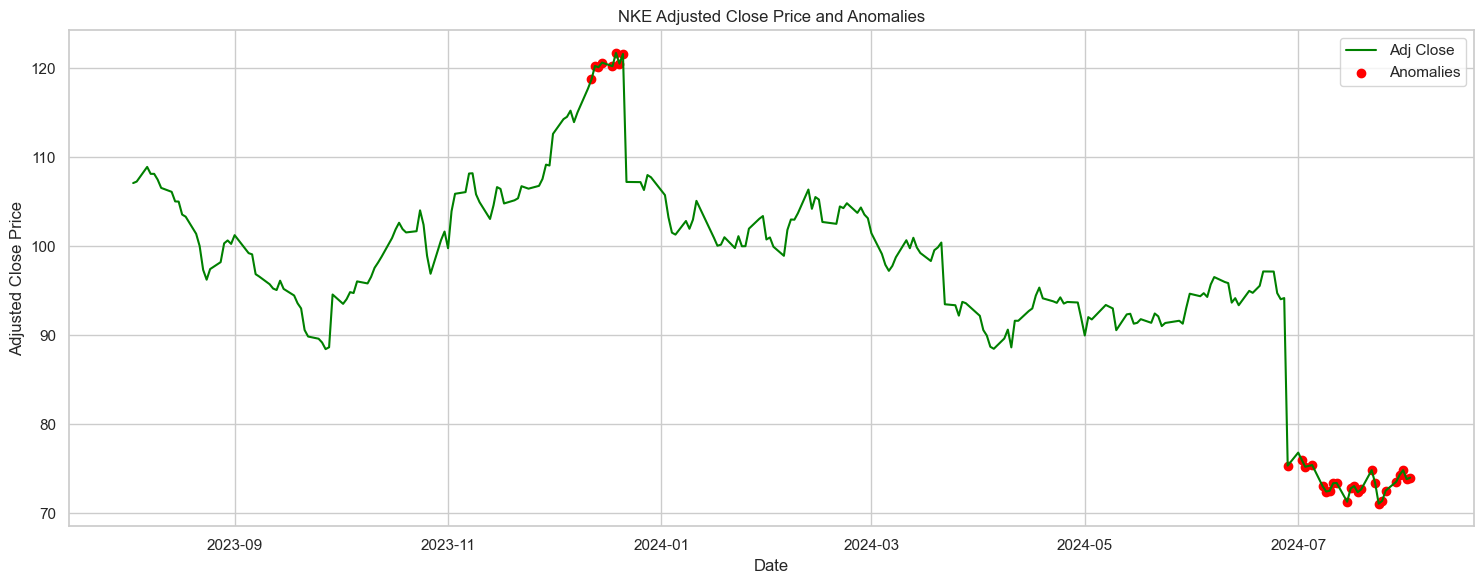

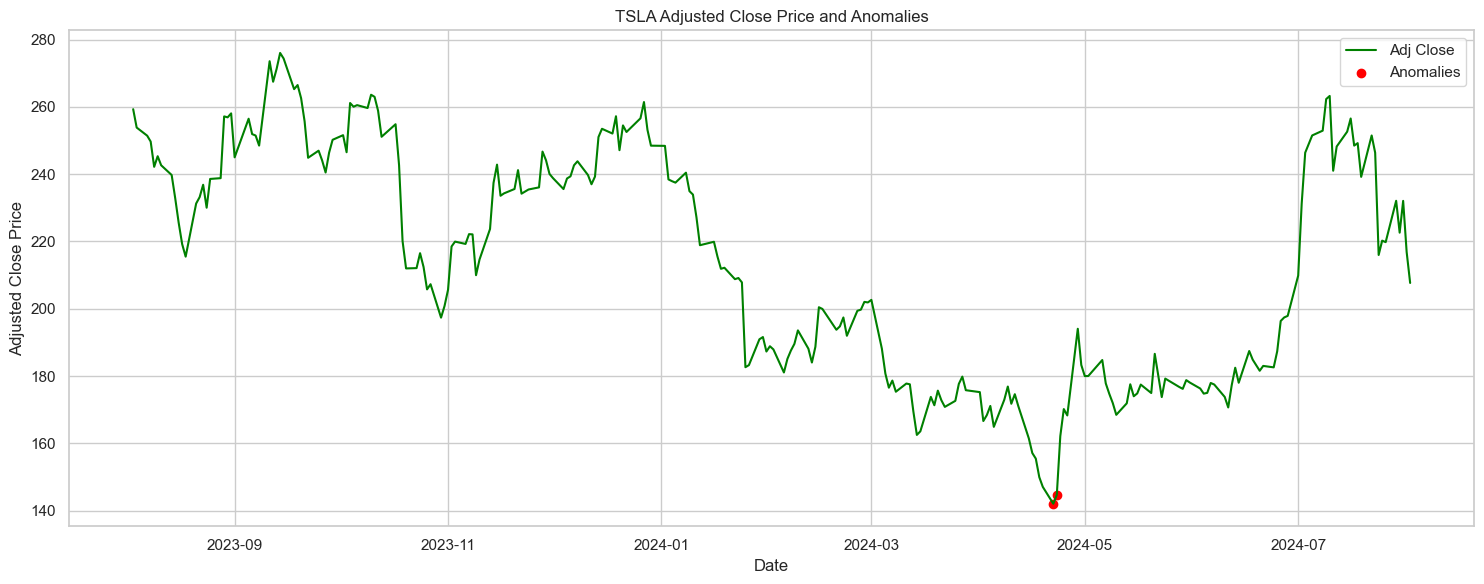

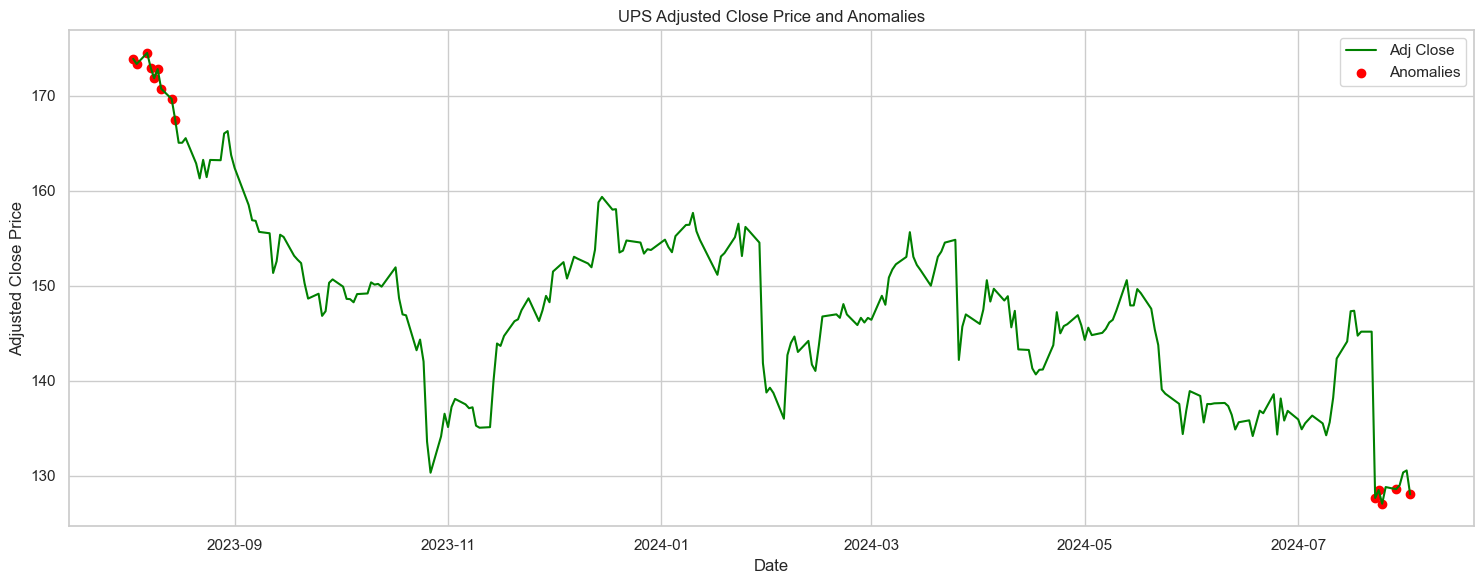

In [107]:
# Afficher les anomalies pour chaque action
for ticker in stock_data['Ticker'].unique():
    plot_anomalies_adj_close(ticker, anomalies_adj_close)

Les graphiques ci-dessus présentent les prix de clôture ajustés de chaque entreprise au fil du temps. Les anomalies, marquées par des points rouges, signalent des écarts significatifs par rapport aux prix normaux, généralement en raison de nouvelles inattendues, d'événements macroéconomiques, de changements géopolitiques ou de variations du marché.

In [108]:
# # Afficher les points d'anomalies pour le volume de chaque action

def plot_anomalies_volume(ticker, anomalies_volume):
    # Filtrer les données principales et les anomalies pour l'action spécifiée
    data_ticker = stock_data[stock_data['Ticker'] == ticker]
    volume_anomalies = anomalies_volume[anomalies_volume['Ticker'] == ticker]
    
    # Créer le graphique
    fig, ax = plt.subplots(figsize=(15, 6))

    # Tracer le volume
    ax.plot(data_ticker.index, data_ticker['Volume'], label='Volume', color='green')
    ax.scatter(volume_anomalies.index, volume_anomalies['Volume'], color='red', label='Anomalies')
    ax.set_title(f'{ticker} Volume and Anomalies')
    ax.set_xlabel('Date')
    ax.set_ylabel('Volume')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

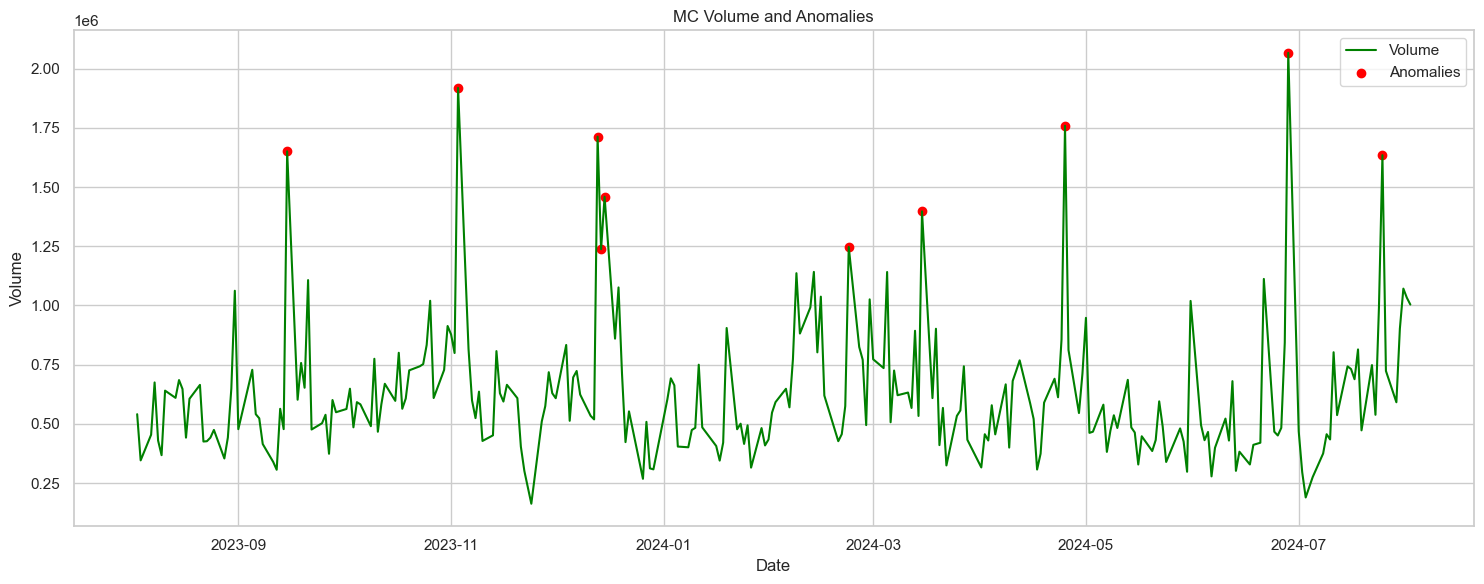

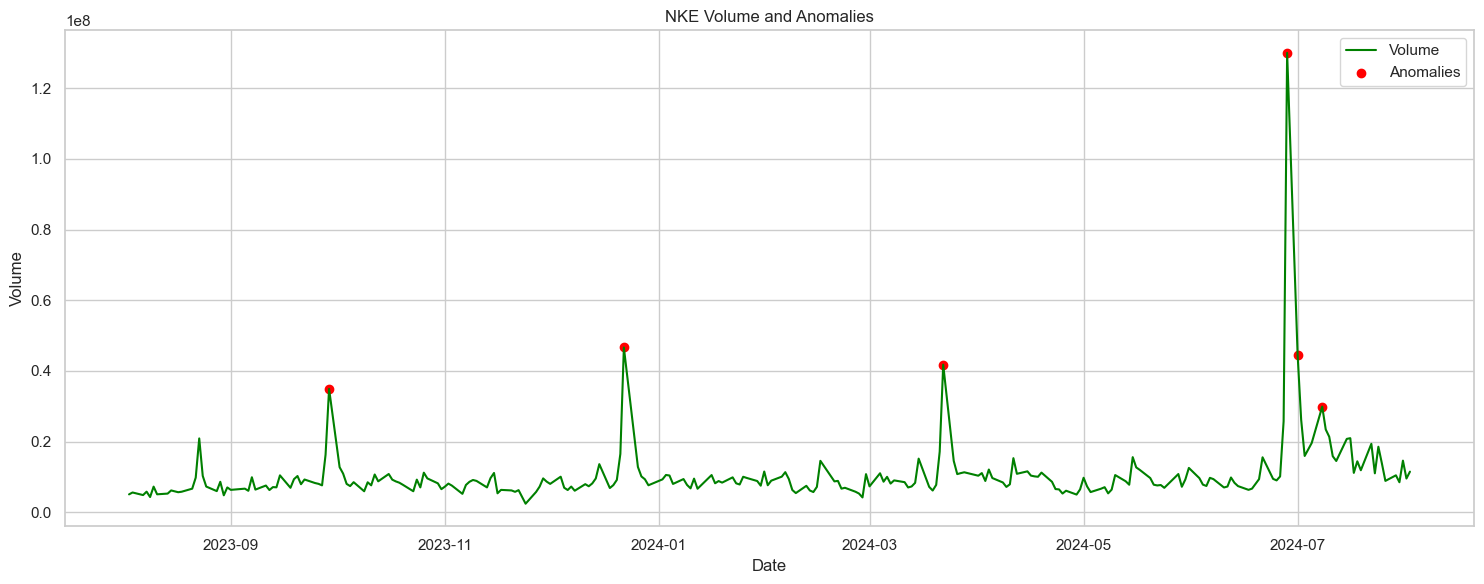

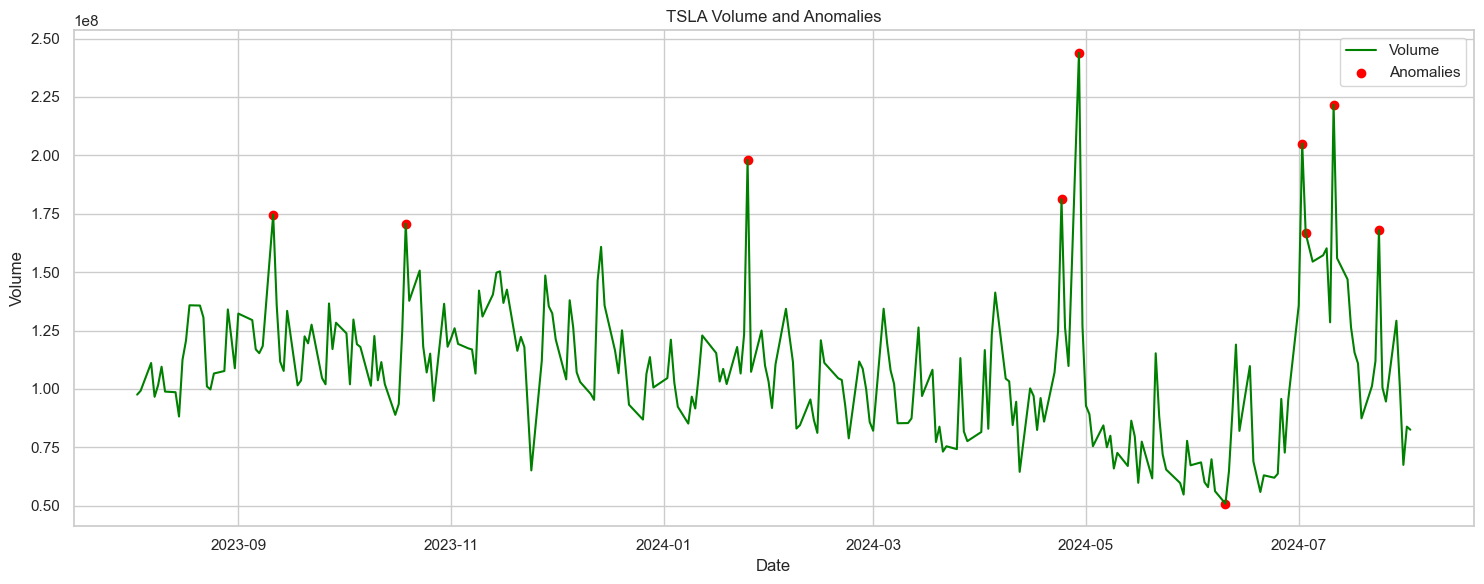

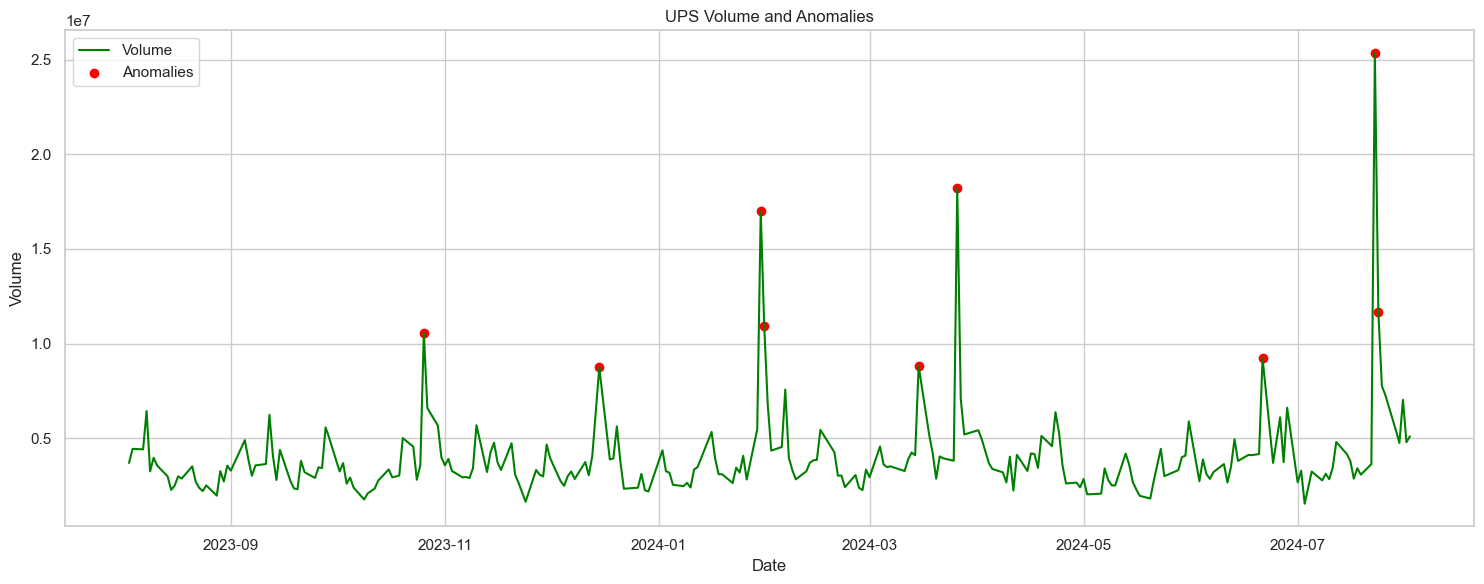

In [109]:
# Afficher les anomalies pour chaque action
for ticker in stock_data['Ticker'].unique():
    plot_anomalies_volume(ticker, anomalies_volume)

Les graphiques ci-dessus montrent les volumes de transactions pour chaque entreprise au fil du temps. Les anomalies, représentées par des pics ou des baisses notables, signalent des journées avec une activité de trading particulièrement élevée ou faible. Ces variations peuvent être attribuées à des événements de marché, des annonces ou d'autres facteurs influençant les comportements des investisseurs.

In [98]:
# Corrélation entre les anomalies Volume et les anomalies Adj_Close

# Copier le dataframe anomalies_adj_close et ne conserver que la colonne 'Ticker'
all_anomalies_adj_close = anomalies_adj_close[['Ticker']].copy()

# Ajouter une colonne 'Adj Close Anomaly' avec la valeur 1 pour indiquer une anomalie
all_anomalies_adj_close['Adj Close Anomaly'] = 1  # variable indicatrice pour les anomalies

# Copier le dataframe anomalies_volume en conservant uniquement la colonne 'Ticker'
all_anomalies_volume = anomalies_volume[['Ticker']].copy()

# Ajouter une colonne 'Volume Anomaly' avec la valeur 1 pour indiquer une anomalie
all_anomalies_volume['Volume Anomaly'] = 1  # variable indicatrice pour les anomalies

# Transformer les dataframes pour obtenir une ligne par date et des colonnes pour chaque ticker, en remplissant les non-anomalies par 0
adj_close_pivot = all_anomalies_adj_close.pivot_table(index=all_anomalies_adj_close.index, columns='Ticker',
                                                       fill_value=0, aggfunc='sum')

volume_pivot = all_anomalies_volume.pivot_table(index=all_anomalies_volume.index, columns='Ticker',
                                                fill_value=0, aggfunc='sum')

# Simplifier l'index des colonnes
adj_close_pivot.columns = adj_close_pivot.columns.get_level_values(1)
volume_pivot.columns = volume_pivot.columns.get_level_values(1)

# Combiner les deux dataframes pivotés
combined_anomalies = pd.concat([adj_close_pivot, volume_pivot], axis=1, keys=['Adj Close Anomaly', 'Volume Anomaly'])

# Calculer la matrice de corrélation des anomalies
correlation_matrix = combined_anomalies.corr()


In [99]:
correlation_matrix

Adj Close Anomaly                                \
Ticker                                  MC       NKE      TSLA       UPS   
                  Ticker                                                   
Adj Close Anomaly MC              1.000000  0.260417 -0.133631 -0.089642   
                  NKE             0.260417  1.000000 -0.356348 -0.567734   
                  TSLA           -0.133631 -0.356348  1.000000 -0.149071   
                  UPS            -0.089642 -0.567734 -0.149071  1.000000   
Volume Anomaly    MC              0.043033       NaN       NaN -0.149071   
                  NKE            -0.222222       NaN       NaN -0.288675   
                  TSLA           -0.356348       NaN       NaN -0.038576   
                  UPS             0.240563       NaN       NaN  0.541667   

                         Volume Anomaly                                
Ticker                               MC       NKE      TSLA       UPS  
                  Ticker                                               
Adj Close Anomaly MC           0.043033 -0.222222 -0.356348  0.240563  
                  NKE               NaN       NaN       NaN       NaN  
                  TSLA              NaN       NaN       NaN       NaN  
                  UPS         -0.149071 -0.288675 -0.038576  0.541667  
Volume Anomaly    MC           1.000000 -0.163396 -0.476190 -0.137314  
                  NKE         -0.163396  1.000000 -0.338062 -0.313340  
                  TSLA        -0.476190 -0.338062  1.000000 -0.289341  
                  UPS         -0.137314 -0.313340 -0.289341  1.000000

NKE a une faible corrélation positive avec MC et une corrélation négative avec TSLA en ce qui concerne les anomalies des prix de clôture ajustés. Cela signifie que les prix de NKE sont quelque peu liés à ceux de MC, mais évoluent en sens inverse par rapport à TSLA. Par ailleurs, UPS et NKE montrent une forte corrélation négative, ce qui indique que lorsque l'un connaît une augmentation (ou une diminution) anormale des prix, l'autre tend à évoluer dans la direction opposée.

Concernant les volumes de transactions, MC montre une corrélation négative avec d'autres entreprises. Cela signifie que lorsque MC a un volume de trading inhabituel, ces autres entreprises ont généralement des anomalies opposées dans leurs volumes de transactions.

# Évaluation des risques liés aux anomalies

In [102]:
# calculer la moyenne des Z-scores absolus pour chaque action comme indicateur de risque
adj_close_risk = anomalies_adj_close.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())
volume_risk = anomalies_volume.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())

# combiner les scores de risque des anomalies de prix et de volume
total_risk = adj_close_risk + volume_risk

# normaliser les scores de risque pour obtenir une évaluation relative du risque de 0 à 1
risk_rating = (total_risk - total_risk.min()) / (total_risk.max() - total_risk.min())

print(round(risk_rating,2))

Ticker
MC      0.41
NKE     1.00
TSLA    0.00
UPS     0.71
Name: Z-score, dtype: float64


MC a un indice de risque d'environ 0,41, indiquant un niveau modéré de risque dû aux anomalies, mais moins élevé que celui de NKE.

UPS présente un indice de risque de 0,71, ce qui le rend plus risqué que MC, mais moins que NKE. Cela suggère une plus grande fréquence d'anomalies dans ses données de trading.

TSLA affiche le risque le plus bas avec un indice de 0,00, indiquant peu ou pas d'anomalies détectables dans ses données de prix et de volume.

NKE a le plus haut indice de risque, à 1,00, ce qui signifie que Nike est la plus risquée parmi ces actions, avec les anomalies les plus fréquentes et les plus significatives.